# Project

## Project description

### Project's objective

Mobile carrier Megaline has found out that many of their subscribers use legacy plans. They want to develop a model that would analyze subscribers' behavior and recommend one of Megaline's newer plans: Smart or Ultra.


### Overview of the data

We have behavior data about subscribers who have already switched to the new plans.
Every observation in the dataset contains monthly behavior information about one user. The information given is as follows:
- сalls — number of calls,
- minutes — total call duration in minutes,
- messages — number of text messages,
- mb_used — Internet traffic used in MB,
- is_ultra — plan for the current month (Ultra - 1, Smart - 0).


### Expected outcomes or results

We will develop a model that will pick the right plan with the highest possible accuracy. 

## Data overview

In [1]:
import pandas as pd
import numpy as np
from sklearn import set_config
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.metrics import matthews_corrcoef
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [2]:
try:
    df = pd.read_csv('/Users/annam/ML Project/users_behavior.csv')  
    
except FileNotFoundError:
    df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head()

calls  minutes  messages   mb_used  is_ultra
0   40.0   311.90      83.0  19915.42         0
1   85.0   516.75      56.0  22696.96         0
2   77.0   467.66      86.0  21060.45         0
3  106.0   745.53      81.0   8437.39         1
4   66.0   418.74       1.0  14502.75         0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


DataFrame consists of 5 columns and 3214 rows with no missing values. 4 columns have float data types and 'is_ultra' has integer data type. 
Each row contains observation about one user for one month.
We have information about number of calls, total call duration in minutes, number of text messages, Internet traffic used in MB and plan for the current month. 

We’ve already performed the data preprocessing step, so we consider the data clean and we can move forward.

Before we start working with models, let's investigate data. 

In [5]:
df.groupby(['is_ultra']).mean().T

is_ultra             0             1
calls        58.463437     73.392893
minutes     405.942952    511.224569
messages     33.384029     49.363452
mb_used   16208.466949  19468.823228

On average users with 'Ultra' plan make more calls with more minutes, write more messages and use more megabytes. Let's see the basic statistics.

In [6]:
for group in df['is_ultra'].unique():
    if group==1:
        result='Ultra'
    else:
        result='Smart'
    print("Basic statistics for",result,"group")
    print("===============================================")
    display(df[df.is_ultra==group].describe())

Basic statistics for Smart group


calls      minutes     messages       mb_used  is_ultra
count  2229.000000  2229.000000  2229.000000   2229.000000    2229.0
mean     58.463437   405.942952    33.384029  16208.466949       0.0
std      25.939858   184.512604    28.227876   5870.498853       0.0
min       0.000000     0.000000     0.000000      0.000000       0.0
25%      40.000000   274.230000    10.000000  12643.050000       0.0
50%      60.000000   410.560000    28.000000  16506.930000       0.0
75%      76.000000   529.510000    51.000000  20043.060000       0.0
max     198.000000  1390.220000   143.000000  38552.620000       0.0

Basic statistics for Ultra group


calls      minutes    messages       mb_used  is_ultra
count  985.000000   985.000000  985.000000    985.000000     985.0
mean    73.392893   511.224569   49.363452  19468.823228       1.0
std     43.916853   308.031100   47.804457  10087.178654       0.0
min      0.000000     0.000000    0.000000      0.000000       1.0
25%     41.000000   276.030000    6.000000  11770.280000       1.0
50%     74.000000   502.550000   38.000000  19308.010000       1.0
75%    104.000000   730.050000   79.000000  26837.720000       1.0
max    244.000000  1632.060000  224.000000  49745.730000       1.0

The same situation we can see in basic statistics.

We have more users with 'Smart' plan. 

In [7]:
df.calls.describe()

count    3214.000000
mean       63.038892
std        33.236368
min         0.000000
25%        40.000000
50%        62.000000
75%        82.000000
max       244.000000
Name: calls, dtype: float64

In [8]:
fig = px.histogram(df,x="calls", 
                   template = "plotly_dark"
                  ).update_layout(xaxis_title="Number of calls", 
                             yaxis_title="Frequency", 
                             title_text='Calls', title_x=0.5)


fig.update_yaxes(range=[0, 250], dtick=50)
fig.update_xaxes(range=[0, 245], dtick=20)
fig.show()



We can see that the majority of users make from 0 to 120 calls per month. The average number of calls per month is 63. Let's calculate 90th, 95th and 99th  percentiles to remove the outliers for our model to work better.

In [9]:
print(np.percentile(df['calls'], [90, 95, 99]))

[104.   120.   163.87]


Not more than 1% of users make more than 163 calls. We will set the number of calls 145 to remove outliers.

In [10]:
df.minutes.describe()

count    3214.000000
mean      438.208787
std       234.569872
min         0.000000
25%       274.575000
50%       430.600000
75%       571.927500
max      1632.060000
Name: minutes, dtype: float64

In [11]:
fig = px.histogram(df,x="minutes",
                   template = "plotly_dark", color_discrete_sequence=['darkorchid']
                  ).update_layout(xaxis_title="Total number of minutes", 
                             yaxis_title="Frequency", 
                             title_text='Minutes', title_x=0.5)


fig.show()

In [12]:
print(np.percentile(df['minutes'], [90, 95, 99]))

[ 730.601   838.226  1153.4978]


Majority of users spend 0-14 hours per month on talking by phone, on average users talk for approximately 7 hours. To remove outliers we will use the number between 95th and 99th percentiles. 

In [13]:
df.messages.describe()

count    3214.000000
mean       38.281269
std        36.148326
min         0.000000
25%         9.000000
50%        30.000000
75%        57.000000
max       224.000000
Name: messages, dtype: float64

In [14]:
fig = px.histogram(df,x="messages",
                   template = "plotly_dark", color_discrete_sequence=['lightseagreen']
                  ).update_layout(xaxis_title="Total number of messages", 
                             yaxis_title="Frequency", 
                             title_text='Messages', title_x=0.5)


fig.show()

In [15]:
print(np.percentile(df['messages'], [90, 95, 99]))

[ 86.   106.   154.87]


Messages are not so popular any more. People prefer to communicate via different messengers. So on average we have 38 messages per month and 636 users wrote from 0 to 4 messages.

In [16]:
df.mb_used.describe()

count     3214.000000
mean     17207.673836
std       7570.968246
min          0.000000
25%      12491.902500
50%      16943.235000
75%      21424.700000
max      49745.730000
Name: mb_used, dtype: float64

In [17]:
fig = px.histogram(df,x="mb_used",
                   template = "plotly_dark", color_discrete_sequence=['lightcoral']
                  ).update_layout(xaxis_title="Megabites used", 
                             yaxis_title="Frequency", 
                             title_text='Megabites', title_x=0.5)


fig.show()

In [18]:
print(np.percentile(df['mb_used'], [90, 95, 99]))

[26667.363  30368.318  38991.7289]


Majority of users use up to 30000 megabytes per month. To remove outliers we will use the number between 95th and 99th percentiles. 

Let's check how many users have 'Ultra' and how many users have 'Smart' plans. It will be the target for our model and the distribution is very important here.

In [19]:
df.is_ultra.value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [20]:
colors = ['dodgerblue', 'hotpink']

fig = go.Figure(data=[go.Pie(labels=['Smart','Ultra'],
                             values=[2229, 985])])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()

We have only 30.6% data for users who have Ultra plans. It means that our data is imbalanced and it will influence the accuracy of our models.

We also noticed that we have users, who didn't use Internet, or write messages, or make calls. Let's see how many such users do we have.

In [21]:
df[(df['minutes'] == 0) | (df['messages'] == 0) | (df['mb_used'] == 0)].shape

(547, 5)

We have 547 such uses. 

Let's check if we have users who didn't use anything at all. 

In [22]:
display(df[(df['minutes'] == 0) & (df['messages'] == 0) & (df['mb_used'] == 0)])

Empty DataFrame
Columns: [calls, minutes, messages, mb_used, is_ultra]
Index: []

We don't have such users in our data.

And let's check how many people used only calls and messages, or used only the Internet.


In [23]:
display(df[(df['minutes'] == 0) & (df['messages'] == 0) | (df['mb_used'] == 0)].reset_index(drop=True))

calls  minutes  messages  mb_used  is_ultra
0    24.0   213.76      21.0     0.00         1
1    41.0   244.59      39.0     0.00         1
2     2.0    11.96       3.0     0.00         1
3    23.0   171.55       2.0     0.00         1
4     4.0    46.98       1.0     0.00         0
5    33.0   215.67      32.0     0.00         1
6    53.0   243.98      41.0     0.00         1
7    40.0   227.89      38.0     0.00         1
8    40.0   300.10      35.0     0.00         1
9    45.0   270.14      29.0     0.00         1
10   44.0   250.07      37.0     0.00         1
11    0.0     0.00       0.0   530.78         1

We have 11 people, who used calls and messages only and one who used the Internet only.

In [24]:
display(df[df['calls'] == 0].reset_index(drop=True))

calls  minutes  messages   mb_used  is_ultra
0     0.0      0.0      33.0  14010.33         1
1     0.0      0.0      35.0  16444.99         1
2     0.0      0.0      21.0  19559.55         0
3     0.0      0.0       8.0  35525.61         1
4     0.0      0.0      25.0  19088.67         1
5     0.0      0.0     191.0  32448.02         1
6     0.0      0.0      24.0  18701.54         1
7     0.0      0.0      30.0  10236.20         1
8     0.0      0.0      32.0  17206.44         0
9     0.0      0.0     180.0  32045.73         1
10    0.0      0.0     185.0  31032.94         1
11    0.0      0.0      29.0  21289.28         1
12    0.0      0.0      35.0  17322.59         0
13    0.0      0.0     201.0  27825.95         1
14    0.0      0.0      30.0  20016.75         1
15    0.0      0.0      20.0  18418.27         1
16    0.0      0.0       9.0   2923.50         1
17    0.0      0.0       7.0  39419.77         1
18    0.0      0.0     188.0  33189.50         1
19    0.0      0.0      28.0  16573.03         1
20    0.0      0.0     211.0  27695.86         1
21    0.0      0.0      19.0  17289.88         1
22    0.0      0.0      20.0  13688.68         1
23    0.0      0.0      48.0  12442.93         0
24    0.0      0.0      30.0  10703.39         1
25    0.0      0.0     173.0  27431.66         1
26    0.0      0.0      44.0  15644.73         1
27    0.0      0.0      14.0  21673.83         1
28    0.0      0.0      24.0  21626.90         1
29    0.0      0.0      32.0  16597.13         1
30    0.0      0.0      42.0  13280.45         1
31    0.0      0.0      28.0  11864.26         1
32    0.0      0.0      23.0  21934.04         1
33    0.0      0.0       6.0  22428.00         1
34    0.0      0.0      17.0  12905.41         1
35    0.0      0.0      20.0  17491.66         0
36    0.0      0.0      17.0  11050.62         0
37    0.0      0.0      31.0  12633.89         1
38    0.0      0.0       0.0    530.78         1
39    0.0      0.0      55.0  10858.90         1

In [25]:
display(df[df['messages'] == 0].reset_index(drop=True))

calls  minutes  messages   mb_used  is_ultra
0    108.0   587.90       0.0  14406.50         1
1      6.0    22.13       0.0   2710.09         0
2      2.0    18.73       0.0    588.89         0
3     41.0   276.81       0.0  19815.62         0
4    120.0   814.85       0.0  20427.00         1
..     ...      ...       ...       ...       ...
492   19.0   165.05       0.0   9607.85         0
493   63.0   422.89       0.0   9697.05         0
494   95.0   646.21       0.0   9432.93         1
495  104.0   702.47       0.0  23611.32         0
496   25.0   190.36       0.0   3275.61         0

[497 rows x 5 columns]

**Conclusions** We can see that we have users with different behavior. In each column we noticed that the minimum value is 0 and there is a big break between 75% and the maximum value. We have 547 users who didn't make calls, or wrote messages, or used mobile Internet for a month: 497 of them didn't write messages, 40 users didn't make calls, 11 users didn't use the Internet  and 1 user used only the Internet. 

We can also see that users with 'Smart' plans for the current month are 2.3 times more than users with 'Ultra'.


To continue, let's remove outliers. We will use values between 95th and 99th percentiles. So let's check how many rows we'll remove.

In [26]:
df[(df['calls'] > 145) | (df['minutes'] >950) | (df['messages'] > 110) | (df['mb_used'] > 38000)].shape


(239, 5)

In [27]:
df = df.drop(df[(df['calls'] > 145) | (df['minutes'] >950) | (df['messages'] > 110) | (df['mb_used'] > 38000)].index)
df.shape

(2975, 5)

We removed outliers, let's check how the data is splitted now.

In [28]:
df.is_ultra.value_counts()

0    2204
1     771
Name: is_ultra, dtype: int64

In [29]:
colors = ['dodgerblue', 'hotpink']

fig = go.Figure(data=[go.Pie(labels=['Smart','Ultra'],
                             values=[2204, 771])])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.show()

We have an imbalanced dataset. After removing outliers our split became 74.1% for 'Smart' users and 25.9% for 'Ultra' users. But after removing outliers the accuracy of our models needs to be higher. 

So let's check what we have on average with clean data.

In [30]:
df.groupby(['is_ultra']).mean().T

is_ultra             0             1
calls        58.034936     65.983139
minutes     402.766438    459.072996
messages     32.616606     34.872892
mb_used   16169.528761  17725.051362

We can see that on average users with 'Ultra' plan use more minutes,messages and megabytes.

We also have obvious high correlation between the parameters, let's check it and remove unnecessary parameters.

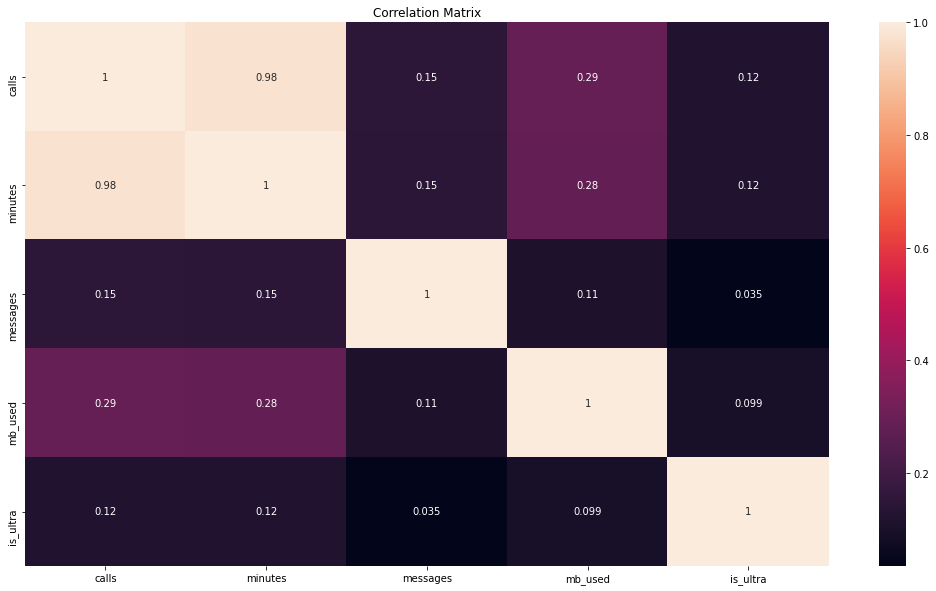

In [31]:
# build and render a correlation matrix
cm = df.corr()  

plt.figure(figsize=(18,10))
sns.heatmap(cm, annot = True)

plt.title('Correlation Matrix')

plt.show()

Minutes and calls have high correlation, we need to drop one of these features not to create overfitting.

In [32]:
df_new = df.drop(['calls'], axis=1)
df_new.head()

minutes  messages   mb_used  is_ultra
0   311.90      83.0  19915.42         0
1   516.75      56.0  22696.96         0
2   467.66      86.0  21060.45         0
3   745.53      81.0   8437.39         1
4   418.74       1.0  14502.75         0

Data is ready for creating models, so let's split it into training, validation and test sets. We will split it  60/20/20 accordingly.

In [33]:
train, valid_test = train_test_split(df_new, test_size=0.4, random_state=12345)
valid, test = train_test_split(valid_test, test_size=0.5, random_state=12345)

In [34]:
display(train.shape)
display(valid.shape)
display(test.shape)

(1785, 4)

(595, 4)

(595, 4)

Now let's split training, validation and test sets into Features and Target.

In [35]:
features_train = train.drop('is_ultra', axis=1)
target_train = train['is_ultra']
features_valid = valid.drop('is_ultra', axis=1)
target_valid = valid['is_ultra']
features_test = test.drop('is_ultra', axis=1)
target_test = test['is_ultra']

Now everything is ready and we can move to creating the models.

## Models.

### Decision tree

Decision trees are a rule-based approach to classification and regression problems. They use the values in each feature to split the dataset to a point where all data points that have the same class are grouped together.

Now it’s time to build the Decision Tree.

In [36]:
dtc_model=DecisionTreeClassifier(random_state=12345)
#training on the train
dtc_model=dtc_model.fit(features_train,target_train)
#fitting predictions on the valid
valid_predictions=dtc_model.predict(features_valid)

In [37]:
score = dtc_model.score(features_valid, target_valid)
score  

0.6957983193277311

Model predicted values with 69.57% of accuracy, the result is not good enough, let's check the depth of our tree.

In [38]:
dtc_model.tree_.max_depth

28

The score is not good enough and the depth of the tree is very high, this can be overfitting, so let's test different depths for the tree and find the best one, which will give the best accuracy.


In [39]:
#creating empty values
final_depth = 0
final_score = 0
#creating the depth range from 1 to 10
for depth in range(1, 11):
    dtc_model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    dtc_model.fit(features_train,target_train)
    valid_predictions = dtc_model.predict(features_valid)
    accuracy = dtc_model.score(features_valid, target_valid)
    if accuracy > final_score:
        final_depth = depth
        final_score = accuracy

print("Final depth=", final_depth,"with training accuracy:",final_score)

Final depth= 8 with training accuracy: 0.7983193277310925


Best depth is not small, let's check what other results we can get.

In [40]:
#creating empty values
final_depth = 0
final_score = 0
#creating the depth range from 1 to 10
for depth in range(1, 11):
    #creating a model
    dtc_model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    #training the model
    dtc_model.fit(features_train,target_train)
    #predicting the values
    valid_predictions = dtc_model.predict(features_valid)
    #calculating accuracy score on validation set
    accuracy = dtc_model.score(features_valid, target_valid)
    print("Final depth=", depth,"with accuracy:",accuracy)

Final depth= 1 with accuracy: 0.7781512605042017
Final depth= 2 with accuracy: 0.788235294117647
Final depth= 3 with accuracy: 0.7915966386554621
Final depth= 4 with accuracy: 0.7899159663865546
Final depth= 5 with accuracy: 0.7815126050420168
Final depth= 6 with accuracy: 0.7865546218487395
Final depth= 7 with accuracy: 0.7899159663865546
Final depth= 8 with accuracy: 0.7983193277310925
Final depth= 9 with accuracy: 0.7932773109243697
Final depth= 10 with accuracy: 0.7848739495798319


We'll use maximum depth 8. Let's visualize our tree and see what we've got. 

In [41]:
dtc_model = DecisionTreeClassifier(random_state=12345, max_depth=8)
dtc_model.fit(features_train,target_train)
dtc_valid_predictions = dtc_model.predict(features_valid)

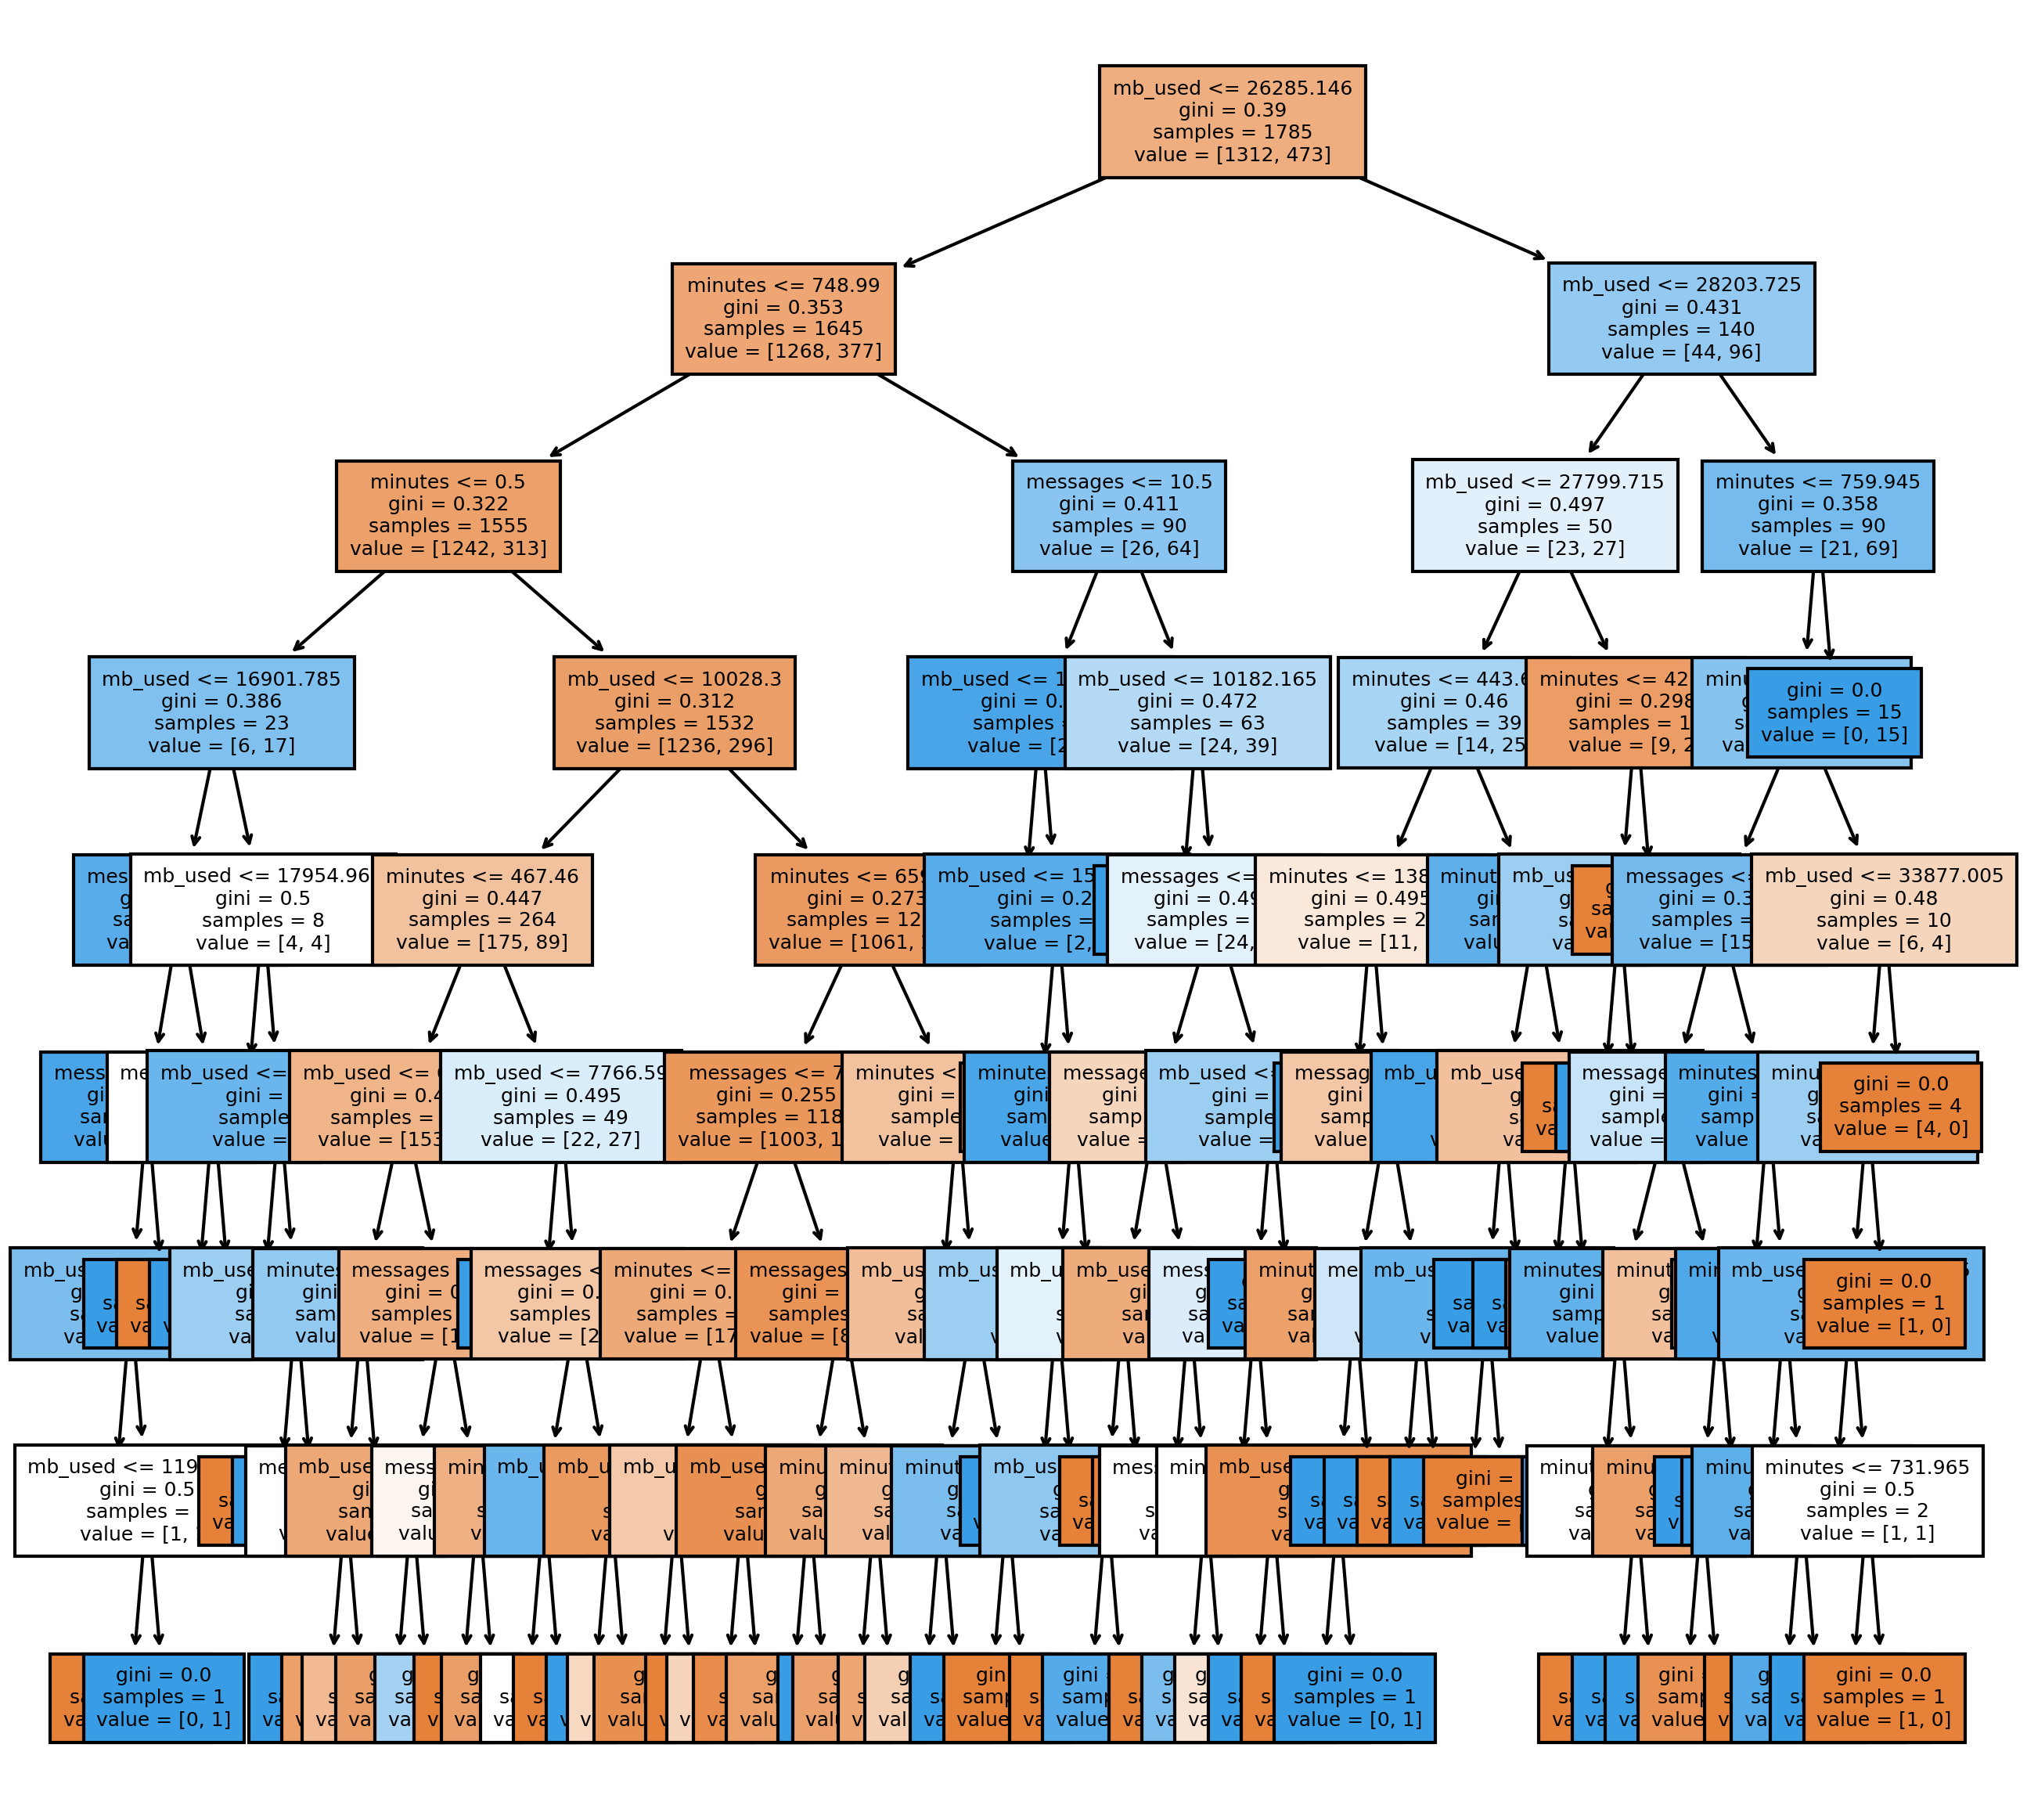

In [42]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10), dpi = 300)
tree.plot_tree(dtc_model,feature_names=features_train.columns,filled=True, fontsize=6)
fig.show()

Let's check the model score on the validation set and accuracy on the test set.

In [43]:
dtc_score = dtc_model.score(features_valid, target_valid)
dtc_predictions_test = dtc_model.predict(features_test)                 
dtc_accuracy_test = accuracy_score(target_test, dtc_predictions_test)  
print("Decision tree training score:", dtc_score)
print("Decision tree testing score:", dtc_accuracy_test)


Decision tree training score: 0.7983193277310925
Decision tree testing score: 0.8218487394957983


We have better results with this depth.
However, there’s a clear trade-off between interpretability and performance.

You can easily visualize and interpret a small tree, but it has high variance. A small change in the training set, may result in a completely different tree, and completely different predictions.

On the other hand, a tall tree with multiple splits generates better classifications. But it’s likely memorizing the training dataset. So it not good at classifying data it has never seen before.

Let's create a function to calculate and plot a confusion matrix.

In [44]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='BuPu'):
    plt.figure(figsize=[8, 6])
    norm_cm = cm
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
    if normalized:
        group_names = group_names
        group_counts = group_counts
        group_percentages = group_percentages
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(norm_cm, annot=labels, annot_kws={"size": 16}, fmt='', xticklabels=classes, yticklabels=classes, cmap=cmap)
        sns.set(font_scale=1.6)


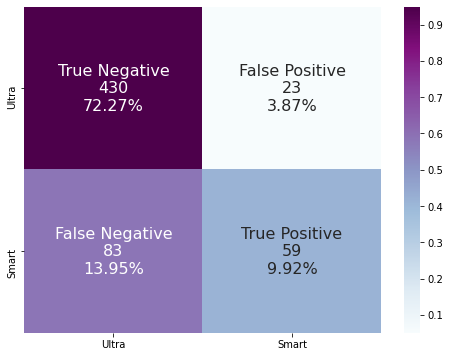

In [45]:
cm = confusion_matrix(target_test, dtc_predictions_test)
#call the confusion matrix function         
plot_confusion_matrix(cm, ['Ultra', 'Smart'])

83 samples (13.95%) that were expected to be of the positive class were classified as the negative class by the model. So it is called “False Negatives” because the model predicted “negative,” which was wrong. 23 samples (3.87%) were expected to be of negative class but were classified as “positive” by the model. They are thus called “False Positives.” We can evaluate the model more closely using these four different numbers from the matrix.

Let's check Precision, Recall and F1 Score by using the classification report. 

In [46]:
print(classification_report(target_test, dtc_predictions_test))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       453
           1       0.72      0.42      0.53       142

    accuracy                           0.82       595
   macro avg       0.78      0.68      0.71       595
weighted avg       0.81      0.82      0.80       595



Precision: A measure of a classifier's exactness and the quality of a positive prediction made by the model.
Recall: A measure of a classifier's completeness, so it answers the question: what proportion of actual positives is correctly classified.
F1 Score (or F-score): The weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.


We have more samples to test from the 'Smart' group, so it has higher results. 


For the final evaluation of our models we will use also the Matthews correlation coefficient.

### Random Forest

Random Forest trains a large quantity of independent trees and makes a decision by voting. A random forest helps to improve results and avoid overfitting.


In [47]:
rfc_model = RandomForestClassifier(random_state=12345)
rfc_model.fit(features_train,target_train)
rfc_valid_predictions = rfc_model.predict(features_valid)
rfc_model_score = rfc_model.score(features_valid, target_valid)
rfc_model_score


0.7647058823529411

From the very beginning Random Forest has better results than Decision Tree.

Let's check the best number of estimators. We'll check the range from 1 to 49.

In [48]:
final_est = 0
final_score = 0
for n in range(1, 50):
    rfc_model = RandomForestClassifier(random_state=12345, n_estimators=n)
    rfc_model.fit(features_train,target_train)
    score = rfc_model.score(features_valid, target_valid)
    if score > final_score:
        final_score = score
        best_est = n
    print(n,final_score)

1 0.680672268907563
2 0.7226890756302521
3 0.7277310924369748
4 0.7495798319327731
5 0.7495798319327731
6 0.7495798319327731
7 0.7495798319327731
8 0.7663865546218488
9 0.7663865546218488
10 0.7663865546218488
11 0.7663865546218488
12 0.7663865546218488
13 0.7663865546218488
14 0.7663865546218488
15 0.7663865546218488
16 0.7663865546218488
17 0.7663865546218488
18 0.7663865546218488
19 0.7663865546218488
20 0.7663865546218488
21 0.7663865546218488
22 0.7663865546218488
23 0.7663865546218488
24 0.7663865546218488
25 0.7663865546218488
26 0.7663865546218488
27 0.7663865546218488
28 0.7663865546218488
29 0.7663865546218488
30 0.7663865546218488
31 0.7663865546218488
32 0.7663865546218488
33 0.7663865546218488
34 0.7663865546218488
35 0.7663865546218488
36 0.7663865546218488
37 0.7663865546218488
38 0.7663865546218488
39 0.7663865546218488
40 0.7663865546218488
41 0.7663865546218488
42 0.7663865546218488
43 0.7663865546218488
44 0.7663865546218488
45 0.7663865546218488
46 0.766386554621848

As we expected, the higher number of trees we have, the better accuracy the model has. We can see that after the 8th estimator we have the same result. Let's check the best depth together with our estimators. As we checked before, we will put the range for estimators from 1 to 9, to save time.




In [49]:
#creating empty values
final_depth = 0
final_est = 0
final_score = 0
#creating the depth range from 1 to 10
for depth in range(1, 11):
    for n in range(1, 9):
        rfc_model = RandomForestClassifier(random_state=12345, n_estimators=n, max_depth=depth)
        rfc_model.fit(features_train,target_train)
        valid_predictions = rfc_model.predict(features_valid)
        accuracy = rfc_model.score(features_valid, target_valid)
        if accuracy > final_score:
            final_depth = depth
            final_score = accuracy
            best_est = n

print("Best number of estimators=", n, "Final depth=", final_depth, "with training accuracy:",final_score)


Best number of estimators= 8 Final depth= 8 with training accuracy: 0.8016806722689076


So let's leave 8 estimators for our model and set maximum depth 8.

In [50]:
rfc_model = RandomForestClassifier(random_state=12345, n_estimators=8, max_depth=8)
rfc_model.fit(features_train,target_train)
rfc_valid_predictions = rfc_model.predict(features_valid)

Let's visualize the first decision tree.

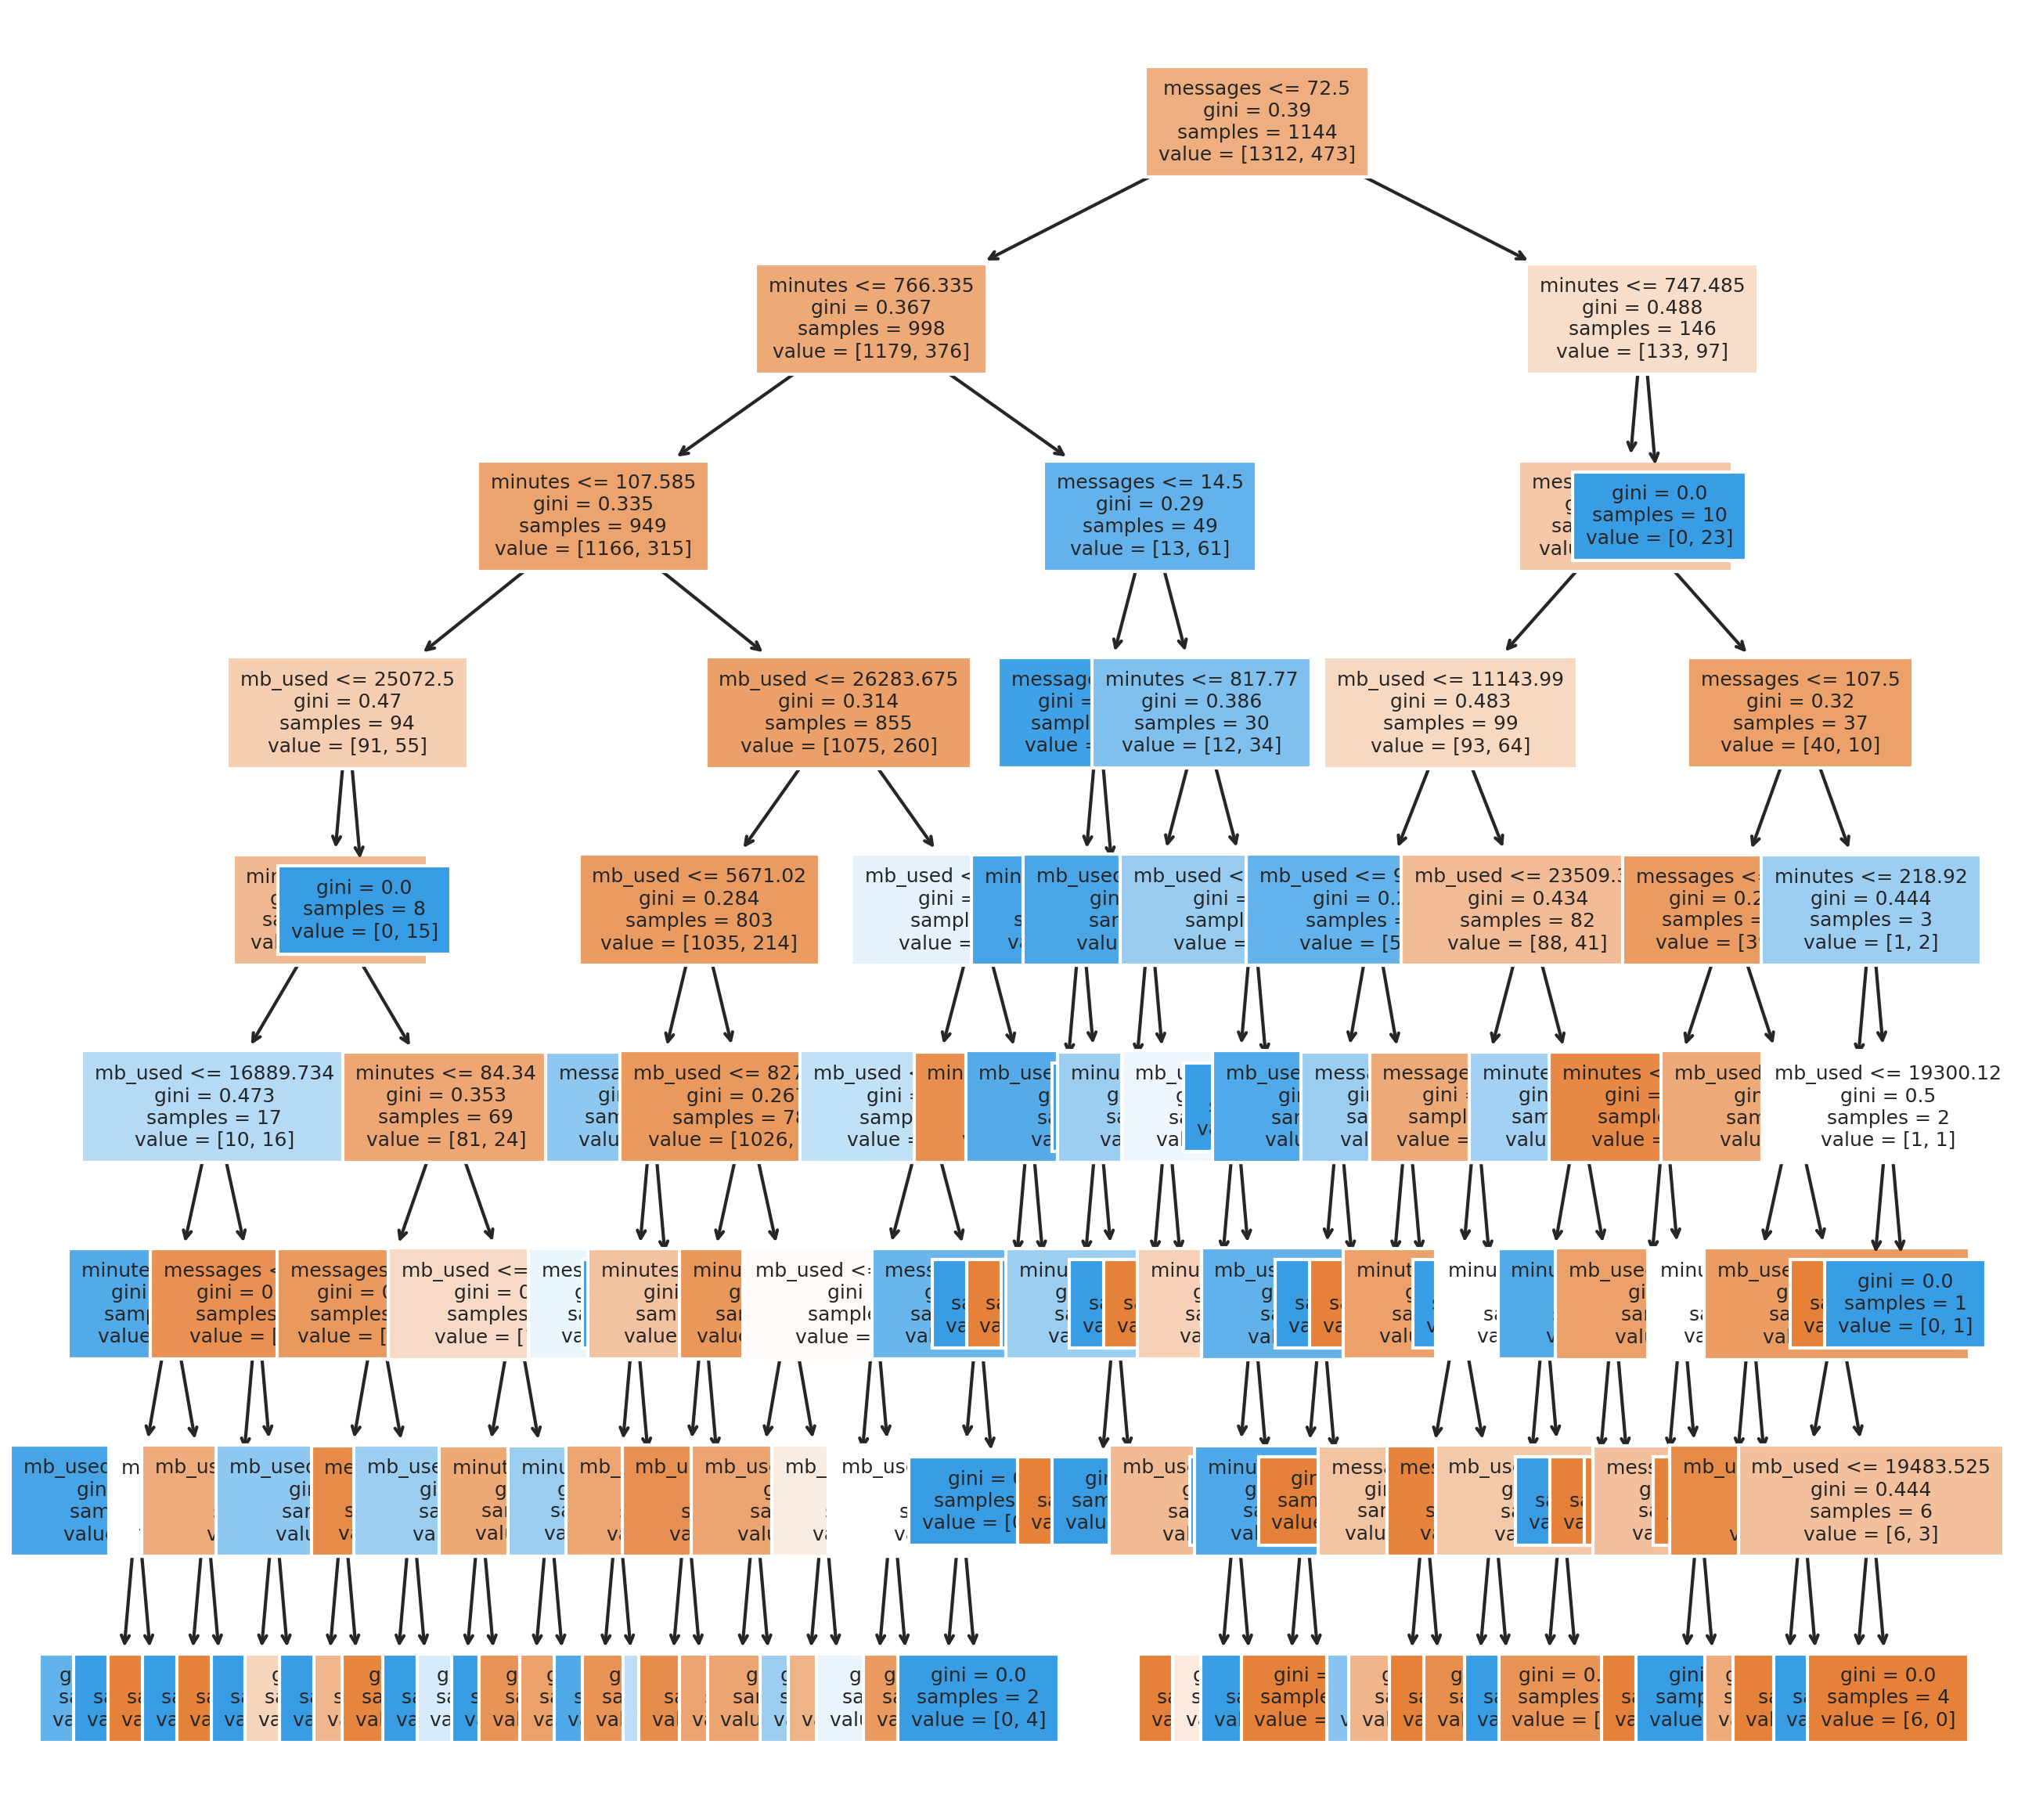

In [51]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10), dpi = 300)
tree.plot_tree(rfc_model.estimators_[0],feature_names=features_train.columns,filled=True, fontsize=6)
fig.show()

In [52]:
rfc_score = rfc_model.score(features_valid, target_valid)
rfc_predictions_test = rfc_model.predict(features_test)                 
rfc_accuracy_test = accuracy_score(target_test, rfc_predictions_test)  
print("Random forest training score:", rfc_score)
print("Random forest testing score:", rfc_accuracy_test)

Random forest training score: 0.8016806722689076
Random forest testing score: 0.826890756302521


Random forest accuracy score is a little higher than decision tree accuracy score.

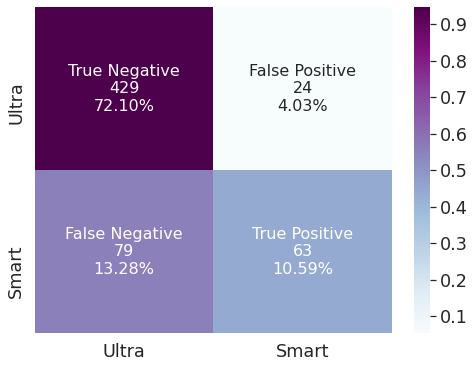

In [53]:
cm = confusion_matrix(target_test, rfc_predictions_test)
#call the confusion matrix function         
plot_confusion_matrix(cm, ['Ultra', 'Smart'])

We have 79 samples (13.28%) False Negative, 24 samples (4.03%) were expected to be of negative class but were classified as “positive” by the model. 

Let's check Precision, Recall and F1 Score by using the classification report. 

In [54]:
print(classification_report(target_test, rfc_predictions_test))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       453
           1       0.72      0.44      0.55       142

    accuracy                           0.83       595
   macro avg       0.78      0.70      0.72       595
weighted avg       0.82      0.83      0.81       595



For Random forest we have better results than for a decision tree model.

### Logistic Regression

Let's try Logistic Regression.

In [55]:
lr_model = LogisticRegression(random_state=12345, solver='liblinear')
lr_model.fit(features_train,target_train)
lr_valid_predictions = lr_model.predict(features_valid)

In [56]:
lr_score = lr_model.score(features_valid, target_valid)
lr_predictions_test = lr_model.predict(features_test) 
lr_accuracy_test = accuracy_score(target_test, lr_predictions_test)
 
print("Logistic regression training score:", lr_score)
print("Logistic regression testing score:", lr_accuracy_test)

Logistic regression training score: 0.7378151260504202
Logistic regression testing score: 0.761344537815126


This model has lower results than other two models. We will not take it into account in future evaluation.

### AdaBoost Classifier

It combines multiple classifiers to increase the accuracy of classifiers. AdaBoost is an iterative ensemble method. AdaBoost classifier builds a strong classifier by combining multiple poorly performing classifiers so that you will get high accuracy strong classifier.
Let's create the AdaBoost Model. AdaBoost uses Decision Tree Classifier as default Classifier.

In [57]:
adaboost_dtc = AdaBoostClassifier(n_estimators=50, random_state=12345, learning_rate=1)
adaboost_dtc.fit(features_train,target_train)
adaboost_dtc_valid_predictions = adaboost_dtc.predict(features_valid)

In [58]:
adaboost_dtc_score = adaboost_dtc.score(features_valid, target_valid)
adaboost_dtc_predictions_test = adaboost_dtc.predict(features_test)                 
adaboost_dtc_accuracy_test = accuracy_score(target_test, adaboost_dtc_predictions_test) 
 
print("Adaboost training score:", adaboost_dtc_score)
print("Adaboost decision tree testing score:", adaboost_dtc_accuracy_test)

Adaboost training score: 0.7932773109243697
Adaboost decision tree testing score: 0.8


Decision tree with hyperparameters has higher accuracy.

In [59]:
print(classification_report(target_test, adaboost_dtc_predictions_test))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       453
           1       0.64      0.38      0.48       142

    accuracy                           0.80       595
   macro avg       0.73      0.66      0.68       595
weighted avg       0.78      0.80      0.78       595



Let's try AdaBoost with Random Forest.

In [60]:
adaboost_rfc = AdaBoostClassifier(base_estimator=rfc_model, n_estimators=50, random_state=12345, learning_rate=1)
adaboost_rfc.fit(features_train,target_train)
adaboost_rfc_valid_predictions = adaboost_rfc.predict(features_valid)

In [61]:
adaboost_rfc_score = adaboost_rfc.score(features_valid, target_valid)
adaboost_rfc_predictions_test = adaboost_rfc.predict(features_test)                 
adaboost_rfc_accuracy_test = accuracy_score(target_test, adaboost_rfc_predictions_test) 
 
print("Adaboost training score:", adaboost_rfc_score)
print("Adaboost random forest testing score:", adaboost_rfc_accuracy_test)

Adaboost training score: 0.7697478991596639
Adaboost random forest testing score: 0.8067226890756303


Random forest has better results than AdaBoost with Random Forest model as base estimator.

### Gradient Boosting Classifier¶

This algorithm builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. 

In [62]:
from sklearn.ensemble import GradientBoostingClassifier
gbm_model = GradientBoostingClassifier(n_estimators=50, random_state=12345, learning_rate=0.1)
gbm_model.fit(features_train,target_train)
gbm_model_valid_predictions = adaboost_rfc.predict(features_valid)

In [63]:
gbm_model_score = gbm_model.score(features_valid, target_valid)
gbm_model_predictions_test = gbm_model.predict(features_test)                 
gbm_model_accuracy_test = accuracy_score(target_test, gbm_model_predictions_test)
print("GBM training score:", gbm_model_score)
print("GBM testing score:", gbm_model_accuracy_test)

GBM training score: 0.7932773109243697
GBM testing score: 0.8168067226890756


In [64]:
print(classification_report(target_test, gbm_model_predictions_test))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       453
           1       0.70      0.41      0.52       142

    accuracy                           0.82       595
   macro avg       0.77      0.68      0.70       595
weighted avg       0.80      0.82      0.80       595



Still, the Random Forest model has better results.

## Final evaluation.

Let's put all our accuracy scores together and check the Matthews correlation coefficient.

In [65]:
print("Decision tree testing score:", dtc_accuracy_test)
print("Random forest testing score:", rfc_accuracy_test)
print("Logistic regression testing score:", lr_accuracy_test)
print("Adaboost decision tree testing score:", adaboost_dtc_accuracy_test)
print("Adaboost random forest testing score:", adaboost_rfc_accuracy_test)
print("GBM testing score:", gbm_model_accuracy_test)

Decision tree testing score: 0.8218487394957983
Random forest testing score: 0.826890756302521
Logistic regression testing score: 0.761344537815126
Adaboost decision tree testing score: 0.8
Adaboost random forest testing score: 0.8067226890756303
GBM testing score: 0.8168067226890756


The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary and multiclass classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. The statistic is also known as the phi coefficient.

In [66]:
print("Decision tree Matthews correlation coefficient:", matthews_corrcoef(target_test, dtc_predictions_test))
print("Random forest Matthews correlation coefficient:", matthews_corrcoef(target_test,  rfc_predictions_test))
print("Adaboost decision tree Matthews correlation coefficient:", matthews_corrcoef(target_test, adaboost_dtc_predictions_test))
print("Adaboost random forest Matthews correlation coefficient:", matthews_corrcoef(target_test, adaboost_rfc_predictions_test))
print("GBM Matthews correlation coefficient:", matthews_corrcoef(target_test, gbm_model_predictions_test))

Decision tree Matthews correlation coefficient: 0.45101152264010336
Random forest Matthews correlation coefficient: 0.47132992530257195
Adaboost decision tree Matthews correlation coefficient: 0.37987709183098634
Adaboost random forest Matthews correlation coefficient: 0.4146855230181813
GBM Matthews correlation coefficient: 0.4346277791623504


## Conclusions

We've developed models that would analyze subscribers' behavior and recommend one of Megaline's newer plans: Smart or Ultra.
The data is imbalanced. We also removed outliers and added hyperparameters to the models to increase their accuracy .
So we developed Decision Tree Classifier model, Random Forest Classifier model, Logistic Regression model, used AdaBoost with Decision tree and Random forest base estimators and tried Gradient Boosting Classifier. 


The best results with accuracy 82.689% and 13.28% 'False Negative', 4.03% 'False Positive' results got **Random Forest Classifier model**. The model also has  highest results in precision, recall, F1-score and Matthews correlation coefficient. 

So we propose to use **Random Forest Classifier model** for our goal.
